## Baseline model from Kaggle
 https://www.kaggle.com/code/chikonzeroselemani/catboost-lightgbm-xgboost

In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from pathlib import Path
from sklearn import preprocessing
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
from sklearn.base import clone
import joblib 
import warnings
warnings.filterwarnings("ignore")

In [2]:
N_FOLDS = 5
ALPHA = 0.10  # 90% coverage
HILL_CLIMB_STEPS = 100
MODEL_NAMES = ["LightGBM", "CatBoost", "XGBoost"]
INITIAL_WEIGHTS = [0.4, 0.3, 0.3]
N_JOBS = -1  # Use all available cores

In [3]:
train_df=pd.read_csv('dataset.csv')
test = pd.read_csv('test.csv')

train_df

,id,sale_date,sale_price,sale_nbr,sale_warning,join_status,join_year,latitude,longitude,area,...,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_lakesamm,view_otherwater,view_other,submarket
0,0,2014-11-15,236000,2.0,,nochg,2025,47.2917,-122.3658,53,...,0,0,0,0,0,0,0,0,0,I
1,1,1999-01-15,313300,NaN,26,nochg,2025,47.6531,-122.1996,74,...,0,0,0,0,0,1,0,0,0,Q
2,2,2006-08-15,341000,1.0,,nochg,2025,47.4733,-122.1901,30,...,0,0,0,0,0,0,0,0,0,K
3,3,1999-12-15,267000,1.0,,nochg,2025,47.4739,-122.3295,96,...,0,0,0,0,0,0,0,0,0,G
4,4,2018-07-15,1650000,2.0,,miss99,2025,47.7516,-122.1222,36,...,0,0,0,0,0,0,0,0,0,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,199995,2000-08-15,277500,1.0,,nochg,2025,47.5503,-122.0285,69,...,0,0,0,0,0,0,0,0,0,O
199996,199996,2019-07-15,1296000,2.0,,new,2025,47.6789,-122.1164,72,...,0,0,0,0,0,0,0,0,0,P
199997,199997,2018-06-15,845000,2.0,,new,2025,47.6939,-122.3542,6,...,0,0,0,0,0,0,0,0,0,B
199998,199998,2018-06-15,890000,2.0,,nochg,2025,47.6433,-122.0613,35,...,0,0,0,0,0,0,0,0,0,O


In [4]:
train_df = train_df.drop(columns=["submarket","subdivision","sale_nbr"])
test = test.drop(columns=["submarket","subdivision","sale_nbr"])
train_df

,id,sale_date,sale_price,sale_warning,join_status,join_year,latitude,longitude,area,city,...,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_lakesamm,view_otherwater,view_other
0,0,2014-11-15,236000,,nochg,2025,47.2917,-122.3658,53,FEDERAL WAY,...,0,0,0,0,0,0,0,0,0,0
1,1,1999-01-15,313300,26,nochg,2025,47.6531,-122.1996,74,KIRKLAND,...,0,0,0,0,0,0,1,0,0,0
2,2,2006-08-15,341000,,nochg,2025,47.4733,-122.1901,30,RENTON,...,0,0,0,0,0,0,0,0,0,0
3,3,1999-12-15,267000,,nochg,2025,47.4739,-122.3295,96,BURIEN,...,0,0,0,0,0,0,0,0,0,0
4,4,2018-07-15,1650000,,miss99,2025,47.7516,-122.1222,36,KING COUNTY,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,199995,2000-08-15,277500,,nochg,2025,47.5503,-122.0285,69,ISSAQUAH,...,0,0,0,0,0,0,0,0,0,0
199996,199996,2019-07-15,1296000,,new,2025,47.6789,-122.1164,72,REDMOND,...,0,0,0,0,0,0,0,0,0,0
199997,199997,2018-06-15,845000,,new,2025,47.6939,-122.3542,6,SEATTLE,...,0,0,0,0,0,0,0,0,0,0
199998,199998,2018-06-15,890000,,nochg,2025,47.6433,-122.0613,35,SAMMAMISH,...,0,0,0,0,0,0,0,0,0,0


<div style="font-family: 'Helvetica Neue', Arial, sans-serif; padding: 20px; background-color: #f9f9f9; border-radius: 8px;">
  <h2 style="color: #2C3E50; margin-bottom: 10px;">
    Data Preprocessing & Feature Engineering
  </h2>
  <hr style="border: none; height: 1px; background-color: #BDC3C7; margin: 15px 0;" />
  <p style="font-size: 16px; line-height: 1.6; color: #34495E; margin-bottom: 15px;">
    In this section, we define a <code>preprocess</code> function to transform raw data into model-ready features. This includes:
  </p>
  <ul style="font-size: 16px; line-height: 1.6; color: #34495E; margin-top: 10px; margin-bottom: 15px; margin-left: 20px;">
    <li>Converting <code>sale_date</code> to datetime and extracting <code>sale_year</code> and <code>sale_month</code>.</li>
    <li>Calculating property <code>age</code>, <code>renovated</code> status, and <code>years_since_reno</code>.</li>
    <li>Combining bathroom counts into <code>total_baths</code> and aggregating land and improvement values into <code>total_value</code>.</li>
    <li>Summing above- and below-ground square footage into <code>living_area</code>.</li>
    <li>Converting select columns to categorical dtype for later encoding.</li>
    <li>Removing unneeded columns (<code>sale_date</code> and <code>id</code>) before returning.</li>
  </ul>
</div>


In [5]:
def preprocess(df):
    # Convert date and extract features
    df['sale_date'] = pd.to_datetime(df['sale_date'])
    df['sale_year'] = df['sale_date'].dt.year
    df['sale_month'] = df['sale_date'].dt.month
    
    # Feature engineering
    df['age'] = df['sale_year'] - df['year_built']
    df['renovated'] = np.where(df['year_reno'] > 0, 1, 0)
    df['years_since_reno'] = np.where(df['renovated'], df['sale_year'] - df['year_reno'], 0)
    df['total_baths'] = df['bath_full'] + 0.75*df['bath_3qtr'] + 0.5*df['bath_half']
    df['total_value'] = df['land_val'] + df['imp_val']
    df['living_area'] = df['sqft'] + df['sqft_fbsmt']
    

    
    # Encode categoricals (simplified example)
    cat_cols = ['sale_warning', 'join_status', 'city', 'zoning']
    for col in cat_cols:
        df[col] = df[col].astype('category')

    
    return df.drop(columns=['sale_date', 'id'])

# Load and preprocess data
train_df = preprocess(train_df)
X_test = preprocess(test)

<div style="font-family: 'Helvetica Neue', Arial, sans-serif; padding: 20px; background-color: #f9f9f9; border-radius: 8px;">
  <h2 style="color: #2C3E50; margin-bottom: 10px;">
    Feature-Target Split &amp; Ordinal Encoding
  </h2>
  <hr style="border: none; height: 1px; background-color: #BDC3C7; margin: 15px 0;" />
  <p style="font-size: 16px; line-height: 1.6; color: #34495E; margin-bottom: 15px;">
    In this step, we separate our training data into feature matrix <code>X</code> and target vector <code>y</code>. Then, we apply ordinal encoding to selected categorical columns to convert them into numeric codes. 
  </p>
</div>


In [6]:
X = train_df.drop(columns=['sale_price'])
y = train_df['sale_price']

# Ordinal encoding.
cat_cols = ['sale_warning', 'join_status', 'city', 'zoning']
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

<div style="font-family: 'Helvetica Neue', Arial, sans-serif; padding: 20px; background-color: #f9f9f9; border-radius: 8px;">
  <h2 style="color: #2C3E50; margin-bottom: 10px;">
    Interval Scoring &amp; Model Training Functions
  </h2>
  <hr style="border: none; height: 1px; background-color: #BDC3C7; margin: 15px 0;" />
  <p style="font-size: 16px; line-height: 1.6; color: #34495E; margin-bottom: 15px;">
    Here we define two utility functions:
  </p>
  <ul style="font-size: 16px; line-height: 1.6; color: #34495E; margin-top: 10px; margin-bottom: 15px; margin-left: 20px;">
    <li><code>winkler_score</code>: Computes the Winkler interval score for prediction intervals, which penalizes both interval width and miscoverage.</li>
    <li><code>train_model</code>: Fits a given model on training data and returns lower and upper quantile predictions for the validation set.</li>
  </ul>
  
</div>
     


In [8]:
def winkler_score(y_true, lower, upper, alpha=ALPHA):
    """Vectorized Mean Winkler Interval Score calculation"""
    width = upper - lower
    below = np.maximum(lower - y_true, 0)
    above = np.maximum(y_true - upper, 0)
    return width + (2/alpha) * (below + above)
    

def train_model(model, X_train, y_train, X_val):
    """Train model and predict on validation set"""
    model.fit(X_train, y_train)
    if isinstance(model, cb.CatBoostRegressor):
        preds = model.predict(X_val)
        means = preds[:, 0]
        stds = np.sqrt(preds[:, 1])
        lower = means - 1.645 * stds
        upper = means + 1.645 * stds
    else:
        lower = model["lower"].predict(X_val)
        upper = model["upper"].predict(X_val)
    return lower, upper

<div style="font-family: 'Helvetica Neue', Arial, sans-serif; padding: 20px; background-color: #f9f9f9; border-radius: 8px;">
  <h2 style="color: #2C3E50; margin-bottom: 10px;">
    Model Definitions &amp; Configuration
  </h2>
  <hr style="border: none; height: 1px; background-color: #BDC3C7; margin: 15px 0;" />
  <p style="font-size: 16px; line-height: 1.6; color: #34495E; margin-bottom: 15px;">
    We define three gradient boosting frameworks—LightGBM, CatBoost, and XGBoost—each configured to predict lower and upper quantiles (where applicable) for a 90% prediction interval. The dictionary below stores these models with their respective hyperparameters:
  </p>
 

</div>


In [9]:
models = {
        "LightGBM": {
            "lower": lgb.LGBMRegressor(
                objective="quantile", 
                alpha=0.05,
                device="gpu",
                n_estimators=1500,
                learning_rate=0.05,
                num_leaves=63,
                subsample=0.8,
                subsample_freq=1,
                random_state=42,
                n_jobs=8
            ),
            "upper": lgb.LGBMRegressor(
                objective="quantile", 
                alpha=0.95,
                device="gpu",
                n_estimators=1500,
                learning_rate=0.05,
                num_leaves=63,
                subsample=0.8,
                subsample_freq=1,
                random_state=42, 
                n_jobs=8
            )
        },
        "CatBoost": cb.CatBoostRegressor(
            loss_function="RMSEWithUncertainty",
            task_type="GPU",
            iterations=1500,
            learning_rate=0.05,
            depth=8,
            verbose=0,
            random_seed=42,
            thread_count=4
        ),
        "XGBoost": {
            "lower": xgb.XGBRegressor(
                objective="reg:quantileerror", 
                quantile_alpha=0.05,
                tree_method="gpu_hist",
                n_estimators=1500,
                learning_rate=0.05,
                max_depth=8,
                subsample=0.8,
                random_state=42, 
                n_jobs=8
            ),
            "upper": xgb.XGBRegressor(
                objective="reg:quantileerror", 
                quantile_alpha=0.95,
                tree_method="gpu_hist",
                n_estimators=1500,
                learning_rate=0.05,
                max_depth=8,
                subsample=0.8,
                random_state=42,
                n_jobs=8
            )
        }
    }
     
   

<div style="font-family: 'Helvetica Neue', Arial, sans-serif; padding: 20px; background-color: #f9f9f9; border-radius: 8px;">
  <h2 style="color: #2C3E50; margin-bottom: 10px;">
    Cross-Validation &amp; Ensemble Optimization
  </h2>
     <hr style="border: none; height: 1px; background-color: #BDC3C7; margin: 15px 0;" />
  <p style="font-size: 16px; line-height: 1.6; color: #34495E;">
    In this section, we initialize arrays to store out-of-fold (OOF) predictions for lower and upper quantiles across all models, then execute a 5-fold cross-validation routine. During each fold, every model—LightGBM, CatBoost, and XGBoost—generates interval estimates for the validation split, which are stored in the OOF arrays. Once the cross-validation is complete, we compute the Mean Winkler Interval Score (MWIS) and coverage percentage for each model’s intervals. Finally, we run a hill-climbing algorithm to search for optimal ensemble weights that minimize the combined MWIS, resulting in a robust weighted interval prediction.
  </p>
</div>


In [10]:
# Initialize storage for OOF predictions
oof_lowers = {model: np.zeros(len(X)) for model in MODEL_NAMES}
oof_uppers = {model: np.zeros(len(X)) for model in MODEL_NAMES}
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
    
print("Starting Cross-Validation...")
for fold, (train_idx, val_idx) in tqdm(enumerate(kf.split(X, y)), total=N_FOLDS, desc="Folds"):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train and predict for each model
    for model_name in MODEL_NAMES:
        if model_name == "CatBoost":
            model = clone(models["CatBoost"])
            model.fit(X_train, y_train)
            preds = model.predict(X_val)
            means = preds[:, 0]
            stds = np.sqrt(preds[:, 1])
            oof_lowers[model_name][val_idx] = means - 1.645 * stds
            oof_uppers[model_name][val_idx] = means + 1.645 * stds
                
        else:
                # Train lower quantile model
            lower_model = clone(models[model_name]["lower"])
            lower_model.fit(X_train, y_train)
            lower_pred = lower_model.predict(X_val)
                
                # Train upper quantile model
            upper_model = clone(models[model_name]["upper"])
            upper_model.fit(X_train, y_train)
            upper_pred = upper_model.predict(X_val)
                
            oof_lowers[model_name][val_idx] = lower_pred
            oof_uppers[model_name][val_idx] = upper_pred
    
    # Calculate MWIS for each model
model_scores = {}
print("\nModel Performance Evaluation:")
for model_name in MODEL_NAMES:
        # Ensure valid intervals
    lower = np.minimum(oof_lowers[model_name], oof_uppers[model_name])
    upper = np.maximum(oof_lowers[model_name], oof_uppers[model_name])
        
        # Calculate MWIS
    wis = winkler_score(y, lower, upper)
    mwis = np.mean(wis)
    model_scores[model_name] = mwis
        
        # Calculate coverage
    coverage = np.mean((y >= lower) & (y <= upper)) * 100
    print(f"{model_name}: MWIS = {mwis:.2f}, Coverage = {coverage:.2f}%")
    
    # Hill Climbing Optimization
print("\nStarting Hill Climbing Optimization...")
current_weights = np.array(INITIAL_WEIGHTS)
best_weights = current_weights.copy()
best_score = float('inf')
    
    # Calculate initial combined score
combined_lower = sum(w * oof_lowers[model] for w, model in zip(current_weights, MODEL_NAMES))
combined_upper = sum(w * oof_uppers[model] for w, model in zip(current_weights, MODEL_NAMES))
current_score = np.mean(winkler_score(y, combined_lower, combined_upper))
    
print(f"Initial MWIS: {current_score:.4f}")
    
    # Optimization loop
for step in tqdm(range(HILL_CLIMB_STEPS), desc="Hill Climbing"):
    improved = False
    candidate_weights = current_weights.copy()
        
        # Generate candidate weights
    perturbation = np.random.dirichlet([5] * len(MODEL_NAMES)) - 0.5/len(MODEL_NAMES)
    candidate_weights = candidate_weights + 0.1 * perturbation
    candidate_weights = np.maximum(candidate_weights, 0)
    candidate_weights /= candidate_weights.sum()
        
        # Calculate combined predictions
    combined_lower = sum(w * oof_lowers[model] for w, model in zip(candidate_weights, MODEL_NAMES))
    combined_upper = sum(w * oof_uppers[model] for w, model in zip(candidate_weights, MODEL_NAMES))
        
        # Calculate MWIS
    candidate_score = np.mean(winkler_score(y, combined_lower, combined_upper))
        
        # Update if improvement
    if candidate_score < best_score:
        best_score = candidate_score
        best_weights = candidate_weights.copy()
        current_weights = candidate_weights.copy()
        improved = True
        print(f"Step {step}: New best MWIS = {best_score:.4f}, Weights = {best_weights}")
    

Starting Cross-Validation...


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4041
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 49
[LightGBM] [Info] Using GPU Device: Tesla V100S-PCIE-32GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (4.27 MB) transferred to GPU in 0.005580 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 185000.000000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4041
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 49
[LightGBM] [Info] Using GPU Device: Tesla V100S-PCIE-32GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[Li

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4034
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 49
[LightGBM] [Info] Using GPU Device: Tesla V100S-PCIE-32GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (4.27 MB) transferred to GPU in 0.005286 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 185000.000000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4034
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 49
[LightGBM] [Info] Using GPU Device: Tesla V100S-PCIE-32GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[Li

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4041
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 49
[LightGBM] [Info] Using GPU Device: Tesla V100S-PCIE-32GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (4.27 MB) transferred to GPU in 0.005197 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 185000.000000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4041
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 49
[LightGBM] [Info] Using GPU Device: Tesla V100S-PCIE-32GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[Li

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4040
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 49
[LightGBM] [Info] Using GPU Device: Tesla V100S-PCIE-32GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (4.27 MB) transferred to GPU in 0.005238 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 185000.000000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4040
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 49
[LightGBM] [Info] Using GPU Device: Tesla V100S-PCIE-32GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[Li

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 49
[LightGBM] [Info] Using GPU Device: Tesla V100S-PCIE-32GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (4.27 MB) transferred to GPU in 0.005525 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 185000.000000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 49
[LightGBM] [Info] Using GPU Device: Tesla V100S-PCIE-32GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[Li


Model Performance Evaluation:
LightGBM: MWIS = 341169.95, Coverage = 83.47%
CatBoost: MWIS = 351910.00, Coverage = 88.03%
XGBoost: MWIS = 348202.01, Coverage = 85.68%

Starting Hill Climbing Optimization...
Initial MWIS: 330465.3138


Hill Climbing:   0%|          | 0/100 [00:00<?, ?it/s]

Step 0: New best MWIS = 330507.9599, Weights = [0.40073032 0.29660315 0.30266654]
Step 3: New best MWIS = 330470.7190, Weights = [0.38802068 0.30578599 0.30619334]
Step 4: New best MWIS = 330268.6027, Weights = [0.37609312 0.32951149 0.29439539]
Step 5: New best MWIS = 330115.2745, Weights = [0.37835213 0.34268371 0.27896415]
Step 6: New best MWIS = 330051.9636, Weights = [0.3723718  0.35434238 0.27328582]
Step 11: New best MWIS = 330008.4592, Weights = [0.35866992 0.37353134 0.26779874]
Step 12: New best MWIS = 329996.3207, Weights = [0.34835117 0.38914528 0.26250355]
Step 14: New best MWIS = 329938.2340, Weights = [0.35969045 0.38405676 0.25625279]
Step 16: New best MWIS = 329931.5356, Weights = [0.35866455 0.38674305 0.2545924 ]
Step 18: New best MWIS = 329826.3863, Weights = [0.37950336 0.37954408 0.24095256]
Step 23: New best MWIS = 329821.1532, Weights = [0.37357478 0.38824314 0.23818207]
Step 31: New best MWIS = 329706.8450, Weights = [0.39555268 0.38405395 0.22039337]
Step 37: 

<div style="font-family: 'Helvetica Neue', Arial, sans-serif; padding: 20px; background-color: #f9f9f9; border-radius: 8px;">
  <h2 style="color: #2C3E50; margin-bottom: 10px;">
    Final Model Training &amp; Prediction Assembly
  </h2>
     <hr style="border: none; height: 1px; background-color: #BDC3C7; margin: 15px 0;" />
  <p style="font-size: 16px; line-height: 1.6; color: #34495E;">
    In this final phase, each model (LightGBM, CatBoost, and XGBoost) is retrained on the entire training dataset to leverage all available information. For CatBoost, we extract both mean and variance to compute lower and upper bounds, while for LightGBM and XGBoost we use separate quantile regressors for the 5th and 95th percentiles. Once individual model predictions on the test set are obtained, we combine them using the optimized ensemble weights determined earlier. The lower and upper bounds are then corrected to ensure proper ordering and non-negative values, resulting in the final prediction intervals ready for submission.
  </p>
</div>


In [11]:
# Final model training
print("\nTraining Final Models...")
test_preds = {"lower": {}, "upper": {}}
    
for model_name in tqdm(MODEL_NAMES, desc="Models"):
    if model_name == "CatBoost":
        model = clone(models["CatBoost"])
        model.fit(X, y)
        preds = model.predict(X_test)
        means = preds[:, 0]
        stds = np.sqrt(preds[:, 1])
        test_preds["lower"][model_name] = means - 1.645 * stds
        test_preds["upper"][model_name] = means + 1.645 * stds
            
    else:
            # Train lower quantile model
        lower_model = clone(models[model_name]["lower"])
        lower_model.fit(X, y)
        test_preds["lower"][model_name] = lower_model.predict(X_test)
            
            # Train upper quantile model
        upper_model = clone(models[model_name]["upper"])
        upper_model.fit(X, y)
        test_preds["upper"][model_name] = upper_model.predict(X_test)
    
    # Combine test predictions
final_lower = sum(best_weights[i] * test_preds["lower"][model] 
                     for i, model in enumerate(MODEL_NAMES))
final_upper = sum(best_weights[i] * test_preds["upper"][model] 
                     for i, model in enumerate(MODEL_NAMES))
    
    # Ensure valid intervals
final_lower, final_upper = np.minimum(final_lower, final_upper), np.maximum(final_lower, final_upper)
final_lower = np.maximum(final_lower, 0)  # Ensure non-negative prices
    



Training Final Models...


Models:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4063
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 49
[LightGBM] [Info] Using GPU Device: Tesla V100S-PCIE-32GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (5.34 MB) transferred to GPU in 0.006168 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 185000.000000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4063
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 49
[LightGBM] [Info] Using GPU Device: Tesla V100S-PCIE-32GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[Li

<div style="font-family: 'Helvetica Neue', Arial, sans-serif; padding: 20px; background-color: #f9f9f9; border-radius: 8px;">
  <h2 style="color: #2C3E50; margin-bottom: 10px;">
    Submission File Creation
  </h2>
     <hr style="border: none; height: 1px; background-color: #BDC3C7; margin: 15px 0;" />
  <p style="font-size: 16px; line-height: 1.6; color: #34495E;">
    Here, we assemble the final DataFrame containing the test IDs alongside their corresponding lower and upper prediction bounds. Once the DataFrame is constructed, it is saved as a CSV file named <code>submission.csv</code>, which is ready for direct upload to the Kaggle competition. A confirmation message is printed upon successful export.
  </p>
</div>


In [11]:
    # Create submission
test_ids = test["id"]
submission = pd.DataFrame({
        "id": test_ids,
        "pi_lower": final_lower,
        "pi_upper": final_upper
    })
submission.to_csv("submission.csv", index=False)
print("Submission saved successfully")

submission = pd.read_csv("submission.csv")
submission.head(5)
    

Submission saved successfully


,id,pi_lower,pi_upper
0,200000,820214.807625,1.122443e+06
1,200001,573894.561657,7.493697e+05
2,200002,466420.676123,6.657043e+05
3,200003,305371.938769,4.374616e+05
4,200004,396455.042123,5.907178e+05


<div style="font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; padding: 20px; background-color: #fcfcfc; border-radius: 8px; border: 1px solid #e0e0e0;">
  <h2 style="color: #1F618D; margin-bottom: 10px;">Final Performance Report</h2>
    <hr style="border: none; height: 1px; background-color: #BDC3C7; margin: 15px 0;" />
  <p style="font-size: 16px; line-height: 1.6; color: #2C3E50;">
    The final evaluation results are presented in a structured console output using the <code>rich</code> library. The first table displays the optimized weights assigned to each model after the hill climbing procedure, reflecting their relative contribution to the ensemble. The second table summarizes the individual MWIS (Mean Winkler Interval Score) of each model across cross-validation folds. Finally, the ensemble’s overall performance, combining all models with optimized weights, is shown in a dedicated section, highlighting the best MWIS achieved.
  </p>
</div>


In [12]:
from rich.console import Console
from rich.table import Table

console = Console()

# Header
console.rule("[bold cyan]FINAL PERFORMANCE REPORT")

# Optimized Weights Table
weights_table = Table(title="Optimized Weights", title_style="bold green")
weights_table.add_column("Model", justify="left", style="cyan")
weights_table.add_column("Weight", justify="right", style="magenta")

for model, weight in zip(MODEL_NAMES, best_weights):
    weights_table.add_row(model, f"{weight:.4f}")

console.print(weights_table)

# Model Performance Table
scores_table = Table(title="Model MWIS Scores", title_style="bold green")
scores_table.add_column("Model", justify="left", style="cyan")
scores_table.add_column("MWIS Score", justify="right", style="yellow")

for model, score in model_scores.items():
    scores_table.add_row(model, f"{score:.4f}")

console.print(scores_table)

# Ensemble Score Highlighted
ensemble_table = Table(title="Ensemble MWIS Score", title_style="bold red")
ensemble_table.add_column("Model", style="bold", justify="left")
ensemble_table.add_column("MWIS Score", style="bold yellow", justify="right")
ensemble_table.add_row("Ensemble", f"{best_score:.4f}")

console.print(ensemble_table)


──────────────────────────────────────────── FINAL PERFORMANCE REPORT ─────────────────────────────────────────────

  Optimized Weights  
┏━━━━━━━━━━┳━━━━━━━━┓
┃ Model    ┃ Weight ┃
┡━━━━━━━━━━╇━━━━━━━━┩
│ LightGBM │ 0.4364 │
│ CatBoost │ 0.3925 │
│ XGBoost  │ 0.1711 │
└──────────┴────────┘

    Model MWIS Scores     
┏━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Model    ┃  MWIS Score ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ LightGBM │ 341169.9483 │
│ CatBoost │ 351909.9961 │
│ XGBoost  │ 348202.0090 │
└──────────┴─────────────┘

   Ensemble MWIS Score    
┏━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Model    ┃  MWIS Score ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Ensemble │ 329488.0692 │
└──────────┴─────────────┘

### Visualization

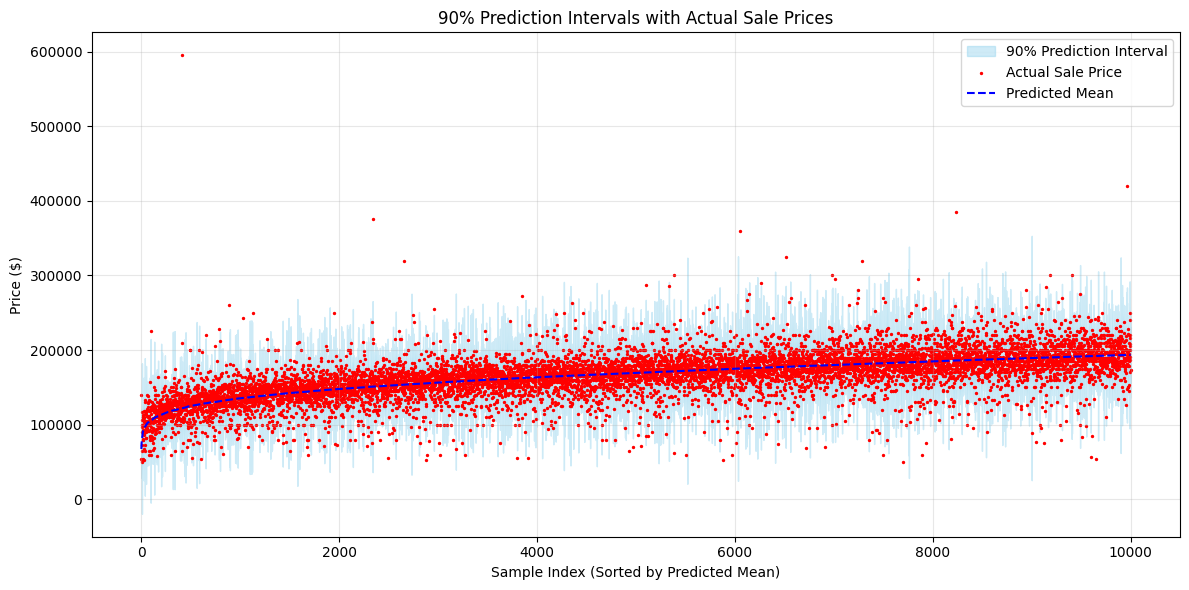

In [13]:
import matplotlib.pyplot as plt
n_samples=10000
final_lower = sum(w * oof_lowers[model] for w, model in zip(best_weights, MODEL_NAMES))
final_upper = sum(w * oof_uppers[model] for w, model in zip(best_weights, MODEL_NAMES))
    
pred_mean = (final_lower + final_upper) / 2
indices = np.argsort(pred_mean)[:n_samples]
final_lower = final_lower[indices]
final_upper = final_upper[indices]
y_true = y.iloc[indices].values
    
plt.figure(figsize=(12, 6))
x = np.arange(n_samples)
plt.fill_between(x, final_lower, final_upper, color='skyblue', alpha=0.4, label='90% Prediction Interval')
plt.scatter(x, y_true, color='red', s=2, label='Actual Sale Price')
plt.plot(x, (final_lower + final_upper) / 2, color='blue', linestyle='--', label='Predicted Mean')
    
plt.xlabel('Sample Index (Sorted by Predicted Mean)')
plt.ylabel('Price ($)')
plt.title('90% Prediction Intervals with Actual Sale Prices')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('prediction_intervals.png')
plt.show()